<a href="https://colab.research.google.com/github/punchnami/AI-Powered-Research-Query-Chatbot/blob/main/PredictiveModel_LSTM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Needed Libraries

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from pandas import Series, DataFrame, concat, read_csv
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from math import sqrt
from keras.layers import LSTM, Dense

#import optuna
#from optuna.integration import TFKerasPruningCallback
#from optuna.integration import KerasPruningCallback

from keras.models import load_model
from keras.models import Sequential

# Data Cleaning & Merging

## Search Sheet

In [4]:
search_file_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/1/Search.xlsx'
df = pd.read_excel(search_file_path)
df_cleaned = df.dropna(axis=1, how='all')
df_cleaned = df_cleaned.drop(columns=['Footnote ID'])
df_cleaned = df_cleaned[df_cleaned['Rate Type'] == 'BGCR']
df_BGCR = df_cleaned.copy()
df_BGCR = df_BGCR.rename(columns={'Effective Date': 'Date'})

## Daily Treasury Rates Sheet

In [5]:
d_treas_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/2 3. Treasury Yield; Yield Spread; Federal'
files_to_concatenate = [
    'daily-treasury-rates_2018.csv',
    'daily-treasury-rates_2019.csv',
    'daily-treasury-rates_2020.csv',
    'daily-treasury-rates_2021.csv',
    'daily-treasury-rates_2022.csv',
    'daily-treasury-rates_2023.csv',
    'daily-treasury-rates_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_rates = merged_df.copy()

## Daily Treasury Rates LT Sheet

In [6]:
files_to_concatenate = [
    'daily-treasury-rates_LT_2018.csv',
    'daily-treasury-rates_LT_2019.csv',
    'daily-treasury-rates_LT_2020.csv',
    'daily-treasury-rates_LT_2021.csv',
    'daily-treasury-rates_LT_2022.csv',
    'daily-treasury-rates_LT_2023.csv',
    'daily-treasury-rates_LT_2024.csv'
]
df_list = []
for file in files_to_concatenate:
    file_path = os.path.join(d_treas_path, file)
    df = pd.read_csv(file_path)
    df_list.append(df)
merged_df = pd.concat(df_list, ignore_index=True)
merged_df = merged_df.dropna(axis=1, how='all')
if 'Footnote ID' in merged_df.columns:
    merged_df = merged_df.drop(columns=['Footnote ID'])
merged_daily_treasury_LT_rates = merged_df.copy()

df_merged = pd.merge(merged_daily_treasury_rates, merged_daily_treasury_LT_rates, on='Date', how='inner')

## Feature Additions

In [7]:
# Calculate short-term yield spreads
df_merged['Yield Spread (4W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (13W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['13 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (26W - 52W)'] = df_merged['52 WEEKS COUPON EQUIVALENT'] - df_merged['26 WEEKS COUPON EQUIVALENT']

# Calculate long-term yield spreads
df_merged['Yield Spread (10Y - 4W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 4W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['4 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (10Y - 52W)'] = df_merged['LT COMPOSITE (>10 Yrs)'] - df_merged['52 WEEKS COUPON EQUIVALENT']
df_merged['Yield Spread (20Y - 52W)'] = df_merged['TREASURY 20-Yr CMT'] - df_merged['52 WEEKS COUPON EQUIVALENT']

In [8]:
columns_to_keep = [
    'Date',
    '4 WEEKS COUPON EQUIVALENT',
    '13 WEEKS COUPON EQUIVALENT',
    '26 WEEKS COUPON EQUIVALENT',
    '52 WEEKS COUPON EQUIVALENT',
    'LT COMPOSITE (>10 Yrs)',
    'TREASURY 20-Yr CMT',
    'Yield Spread (4W - 52W)',
    'Yield Spread (13W - 52W)',
    'Yield Spread (26W - 52W)',
    'Yield Spread (10Y - 4W)',
    'Yield Spread (20Y - 4W)',
    'Yield Spread (10Y - 52W)',
    'Yield Spread (20Y - 52W)'
]
df_relevant = df_merged[columns_to_keep]

df_merged = pd.merge(df_BGCR, df_relevant, on='Date', how='inner')
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

## CPI

In [9]:
cpi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [247.867, 251.712, 257.971, 261.582, 281.148, 299.170, 308.417],
    'Feb': [248.991, 252.776, 258.678, 263.014, 283.716, 300.840, 310.326],
    'Mar': [249.554, 254.202, 258.115, 264.877, 287.504, 301.836, 312.332],
    'Apr': [250.546, 255.548, 256.389, 267.054, 289.109, 303.363, 313.548],
    'May': [251.588, 256.092, 256.934, 269.195, 292.296, 304.127, 314.069],
    'Jun': [251.988, 256.143, 257.797, 271.696, 296.311, 305.109, 314.069],
    'Jul': [252.006, 256.571, 259.101, 273.003, 296.276, 305.691, None],
    'Aug': [252.146, 256.558, 259.918, 273.567, 296.171, 307.026, None],
    'Sep': [252.439, 256.759, 260.280, 274.310, 296.908, 307.789, None],
    'Oct': [252.885, 257.346, 260.388, 276.589, 298.012, 307.671, None],
    'Nov': [252.038, 257.346, 260.229, 277.948, 297.711, 307.051, None],
    'Dec': [251.233, 257.208, 260.474, 278.802, 296.797, 306.746, None]
}


cpi_df = pd.DataFrame(cpi_data)
cpi_long_df = pd.melt(cpi_df, id_vars=['Year'], var_name='Month', value_name='CPI')
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
cpi_long_df['Month'] = cpi_long_df['Month'].map(month_mapping)
cpi_long_df['Day'] = 1
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df[['Year', 'Month', 'Day']])
cpi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)
cpi_long_df.set_index('Date', inplace=True)
cpi_long_df = cpi_long_df.resample('D').ffill()
cpi_long_df.reset_index(inplace=True)
cpi_long_df['Date'] = pd.to_datetime(cpi_long_df['Date'])

df_merged2 = pd.merge(df_merged, cpi_long_df[['Date', 'CPI']], on='Date', how='left')

## SPX

In [10]:
spx_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719610851813_SPX.csv'
df = pd.read_csv(spx_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'SPX'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged3 = pd.merge(df_merged2, df, on='Date', how='inner')

## NASDAQ

In [11]:
nasdaq_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalData_1719611009685_COMP.csv'
df = pd.read_csv(nasdaq_path)
df = df.drop(columns=['Open', 'High', 'Low'])
df = df.rename(columns={'Close/Last': 'NASDAQ'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged4 = pd.merge(df_merged3, df, on='Date', how='inner')

## DJIA

In [12]:
djia_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/6. Stock Market Data/HistoricalPrices_DJIA.csv'
df = pd.read_csv(djia_path)
df = df.drop(columns=[' Open', ' High', ' Low'], axis=1)
df = df.rename(columns={' Close': 'DJIA'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged5 = pd.merge(df_merged4, df, on='Date', how='inner')

<ipython-input-12-884830d5858d>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'])


## Foreign Exchange Rate

In [13]:
forex_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/7. FX/FRB_H10.csv'
df = pd.read_csv(forex_path)
df = df.iloc[5:]
df.rename(columns={'Series Description': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

df_merged6 = pd.merge(df_merged5, df, on='Date', how='inner')

## PPI

In [14]:
ppi_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [114.8, 117, 119.3, 121.2, 133.576, 141.286, 142.683],
    'Feb': [115.1, 117.2, 118.6, 122, 134.821, 141.237, 143.509],
    'Mar': [115.3, 117.6, 118, 122.8, 137.041, 140.738, 143.410],
    'Apr': [115.5, 118.2, 116.6, 124.1, 137.805, 140.977, 144.119],
    'May': [115.9, 118.3, 117.2, 125.3, 139.026, 140.664, 144.079],
    'Jun': [116.3, 118.2, 117.5, 126.2, 140.238, 140.672, 144.402],
    'Jul': [116.4, 118.5, 118.2, 127.504, 139.837, 141.461, None],
    'Aug': [116.5, 118.6, 118.4, 128.574, 139.721, 142.353, None],
    'Sep': [116.7, 118.3, 118.7, 129.188, 140.137, 142.658, None],
    'Oct': [117.5, 118.8, 119.4, 130.061, 140.666, 142.191, None],
    'Nov': [117.4, 118.6, 119.5, 131.455, 141.18, 142.267, None],
    'Dec': [117.4, 119, 120, 132.224, 140.696, 142.17, None]
}

# Converting PPI data to DataFrame
ppi_df = pd.DataFrame(ppi_data)

# Melting the PPI DataFrame to long format
ppi_long_df = pd.melt(ppi_df, id_vars=['Year'], var_name='Month', value_name='PPI')

# Mapping month names to numbers
month_mapping = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
ppi_long_df['Month'] = ppi_long_df['Month'].map(month_mapping)

# Creating a 'Day' column with value 1 for each row
ppi_long_df['Day'] = 1

# Creating a date column in the PPI DataFrame
ppi_long_df['Date'] = pd.to_datetime(ppi_long_df[['Year', 'Month', 'Day']])

# Dropping unnecessary columns
ppi_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
ppi_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known PPI value of each month
ppi_long_df = ppi_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
ppi_long_df.reset_index(inplace=True)

ppi_long_df['Date'] = pd.to_datetime(ppi_long_df['Date'])
df_merged7 = pd.merge(df_merged6, ppi_long_df[['Date', 'PPI']], on='Date', how='inner')

## Unemployment Rate

In [15]:
unemp_data = {
    'Year': [2018, 2019, 2020, 2021, 2022, 2023, 2024],
    'Jan': [4, 4, 3.6, 6.4, 4, 3.4, 3.7],
    'Feb': [4.1, 3.8, 3.5, 6.2, 3.8, 3.6, 3.9],
    'Mar': [4, 3.8, 4.4, 6.1, 3.6, 3.5, 3.8],
    'Apr': [4, 3.7, 14.8, 6.1, 3.7, 3.4, 3.9],
    'May': [3.8, 3.6, 13.2, 5.8, 3.6, 3.7, 4],
    'Jun': [4, 3.6, 11, 5.9, 3.6, 3.6, 4.1],
    'Jul': [3.8, 3.7, 10.2, 5.4, 3.5, 3.5, None],
    'Aug': [3.8, 3.6, 8.4, 5.1, 3.6, 3.8, None],
    'Sep': [3.7, 3.5, 7.8, 4.7, 3.5, 3.8, None],
    'Oct': [3.8, 3.6, 6.8, 4.5, 3.6, 3.8, None],
    'Nov': [3.8, 3.6, 6.7, 4.1, 3.6, 3.7, None],
    'Dec': [3.9, 3.6, 6.7, 3.9, 3.5, 3.7, None]
}

# Converting Unempl data to DataFrame
unemp_df = pd.DataFrame(unemp_data)

# Melting the Unempl DataFrame to long format
unemp_long_df = pd.melt(unemp_df, id_vars=['Year'], var_name='Month', value_name='Unemployment')

# Maunempng month names to numbers
month_maunempng = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}
unemp_long_df['Month'] = unemp_long_df['Month'].map(month_maunempng)

# Creating a 'Day' column with value 1 for each row
unemp_long_df['Day'] = 1

# Creating a date column in the Unempl DataFrame
unemp_long_df['Date'] = pd.to_datetime(unemp_long_df[['Year', 'Month', 'Day']])

# Drounempng unnecessary columns
unemp_long_df.drop(['Year', 'Month', 'Day'], axis=1, inplace=True)

# Setting the Date as the index
unemp_long_df.set_index('Date', inplace=True)

# Reindexing to fill in missing dates with forward fill for the last known Unempl value of each month
unemp_long_df = unemp_long_df.resample('D').ffill()

# Reset the index to have Date as a column again
unemp_long_df.reset_index(inplace=True)

unemp_long_df['Date'] = pd.to_datetime(unemp_long_df['Date'])
df_merged8 = pd.merge(df_merged7, unemp_long_df[['Date', 'Unemployment']], on='Date', how='inner')

## Overnight Reverse Repo Facility (RRP)

In [16]:
rrp_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Additional data/RRPONTSYD.csv'
df = pd.read_csv(rrp_path)
df = df.rename(columns={'DATE': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged9 = pd.merge(df_merged8, df, on='Date', how='inner')

## Fed Security Holdings

In [17]:
security_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Additional data/WSHOSHO.csv'
df = pd.read_csv(security_path)
df = df.rename(columns={'DATE': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)
# Resample the weekly data to daily frequency, using forward fill to fill in the missing days
df = df.resample('D').ffill()

df_merged10 = pd.merge(df_merged9, df, on='Date', how='inner')

In [18]:
df_merged10

,Date,Rate Type,Rate (%),1st Percentile (%),25th Percentile (%),75th Percentile (%),99th Percentile (%),Volume ($Billions),4 WEEKS COUPON EQUIVALENT,13 WEEKS COUPON EQUIVALENT,...,NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",PPI,Unemployment,RRPONTSYD,WSHOSHO
0,2024-06-21,BGCR,5.30,5.25,5.30,5.31,5.37,760,5.31,5.37,...,17689.36,39150.33,1.0694,1.2645,7.2609,159.4500,144.402,4.1,421.04,6810058.0
1,2024-06-20,BGCR,5.31,5.25,5.31,5.31,5.36,767,5.31,5.38,...,17721.59,39134.76,1.0708,1.2671,7.2604,158.7700,144.402,4.1,388.841,6810058.0
2,2024-06-18,BGCR,5.32,5.25,5.32,5.32,5.41,763,5.29,5.38,...,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100,144.402,4.1,375.542,6818650.0
3,2024-06-17,BGCR,5.32,5.26,5.31,5.32,5.42,772,5.34,5.39,...,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000,144.402,4.1,333.429,6818650.0
4,2024-06-14,BGCR,5.30,5.25,5.30,5.31,5.37,785,5.35,5.39,...,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800,144.402,4.1,386.885,6818650.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,2018-04-06,BGCR,1.70,1.60,1.70,1.70,1.83,352,1.67,1.73,...,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300,115.500,4.0,4.895,4171790.0
1552,2018-04-05,BGCR,1.70,1.60,1.70,1.70,1.85,349,1.66,1.72,...,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800,115.500,4.0,4.645,4171790.0
1553,2018-04-04,BGCR,1.70,1.57,1.70,1.70,1.81,348,1.68,1.71,...,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600,115.500,4.0,4.57,4171790.0
1554,2018-04-03,BGCR,1.81,1.50,1.80,1.82,1.97,344,1.70,1.75,...,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500,115.500,4.0,8.695,4183642.0


## Probability of rate hike/cut



In [19]:
hikecut_path = '/content/drive/MyDrive/Colab Notebooks/Predictive Model/Predictive Model/Additional data/Bloomberg data - WIRP AUG8 2024.csv'
df = pd.read_csv(hikecut_path)
df = df.rename(columns={'Data': 'Date'})
df['Date'] = pd.to_datetime(df['Date'])

df_merged11 = pd.merge(df_merged10, df, on='Date', how='inner')

## Consolidated df

In [20]:
df_final = df_merged11.copy()
df_final = df_final.drop(columns=[ 'Rate Type','1st Percentile (%)', '25th Percentile (%)', '75th Percentile (%)', '99th Percentile (%)',
                                  '4 WEEKS COUPON EQUIVALENT', '13 WEEKS COUPON EQUIVALENT', '26 WEEKS COUPON EQUIVALENT', '52 WEEKS COUPON EQUIVALENT'])

In [21]:
# Drop additional columns with high co-linearity (note: this is done in second iteration of model training/development)
df_final = df_final.drop(columns=['TREASURY 20-Yr CMT', 'Yield Spread (13W - 52W)', 'Yield Spread (20Y - 4W)', 'Yield Spread (20Y - 52W)','CPI', 'SPX', 'PPI'])

In [22]:
# Set the 'Date' column as the index
df_final.set_index('Date', inplace=True)
df_final2 = df_final.sort_index(ascending=True)
df_final2

,Rate (%),Volume ($Billions),LT COMPOSITE (>10 Yrs),Yield Spread (4W - 52W),Yield Spread (26W - 52W),Yield Spread (10Y - 4W),Yield Spread (10Y - 52W),NASDAQ,DJIA,SPOT EXCHANGE RATE - EURO AREA,"UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)","CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.","JAPAN -- SPOT EXCHANGE RATE, YEN/US$",Unemployment,RRPONTSYD,WSHOSHO,#Hikes/Cuts
Date,,,,,,,,,,,,,,,,,
2018-04-02,1.77,361,2.90,0.41,0.16,1.23,0.82,6870.12,23644.19,1.2288,1.4032,6.2785,105.9900,4.0,3.823,4183642.0,0.012
2018-04-03,1.81,344,2.96,0.39,0.17,1.26,0.87,6941.28,24033.36,1.2261,1.4068,6.2881,106.4500,4.0,8.695,4183642.0,0.023
2018-04-04,1.70,348,2.97,0.39,0.17,1.29,0.90,7042.11,24264.30,1.2292,1.4076,6.3045,106.5600,4.0,4.57,4171790.0,0.001
2018-04-05,1.70,349,3.01,0.41,0.15,1.35,0.94,7076.55,24505.22,1.2230,1.3991,6.3045,107.4800,4.0,4.645,4171790.0,0.012
2018-04-06,1.70,352,2.94,0.39,0.16,1.27,0.88,6915.11,23932.76,1.2274,1.4088,6.3045,107.0300,4.0,4.895,4171790.0,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-14,5.30,785,4.42,-0.29,-0.29,-0.93,-0.64,17688.88,38589.16,1.0699,1.2685,7.2557,157.2800,4.1,386.885,6818650.0,-0.120
2024-06-17,5.32,772,4.48,-0.23,-0.26,-0.86,-0.63,17857.02,38778.10,1.0723,1.2689,7.2561,157.8000,4.1,333.429,6818650.0,-0.080
2024-06-18,5.32,763,4.43,-0.20,-0.27,-0.86,-0.66,17862.23,38834.86,1.0739,1.2699,7.2543,157.8100,4.1,375.542,6818650.0,-0.100


In [23]:
df_final2 = df_final2.apply(pd.to_numeric, errors='coerce')

In [24]:
print(df_final2.isnull().sum())

Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
Yield Spread (4W - 52W)                                           0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
NASDAQ                                                            0
DJIA                                                              0
SPOT EXCHANGE RATE - EURO AREA                                    8
UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)    8
CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.                        8
JAPAN -- SPOT EXCHANGE RATE, YEN/US$                              8
Unemployment                                                      0
RRPONTSYD                                       

In [25]:
# Drop rows with NaN values in the dataframe
df_final2.dropna(inplace=True)

In [26]:
# Re-check for any remaining NaN values
print("\n\nNaN values in original features dataframe after dropping:")
print(df_final2.isna().sum())



NaN values in original features dataframe after dropping:
Rate (%)                                                          0
Volume ($Billions)                                                0
LT COMPOSITE (>10 Yrs)                                            0
Yield Spread (4W - 52W)                                           0
Yield Spread (26W - 52W)                                          0
Yield Spread (10Y - 4W)                                           0
Yield Spread (10Y - 52W)                                          0
NASDAQ                                                            0
DJIA                                                              0
SPOT EXCHANGE RATE - EURO AREA                                    0
UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)    0
CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.                        0
JAPAN -- SPOT EXCHANGE RATE, YEN/US$                              0
Unemployment                                            

# Preliminary EDA

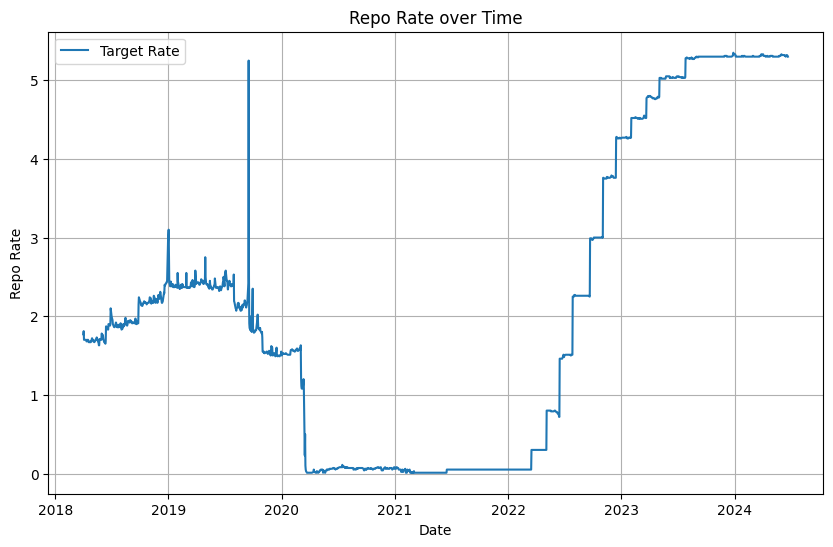

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df_final2.index, df_final2['Rate (%)'], label='Target Rate')
plt.xlabel('Date')
plt.ylabel('Repo Rate')
plt.title('Repo Rate over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(df_final2.describe())

          Rate (%)  Volume ($Billions)  LT COMPOSITE (>10 Yrs)  \
count  1541.000000         1541.000000             1541.000000   
mean      2.119896          449.541856                2.862362   
std       1.939072          103.794554                1.086422   
min       0.010000          303.000000                0.970000   
25%       0.060000          369.000000                1.980000   
50%       1.870000          415.000000                2.920000   
75%       3.770000          496.000000                3.780000   
max       5.350000          794.000000                5.280000   

       TREASURY 20-Yr CMT  Yield Spread (4W - 52W)  Yield Spread (13W - 52W)  \
count         1541.000000              1541.000000               1541.000000   
mean             2.855730                 0.229384                  0.112511   
std              1.116531                 0.499733                  0.349571   
min              0.870000                -1.020000                 -0.700000   
25%  

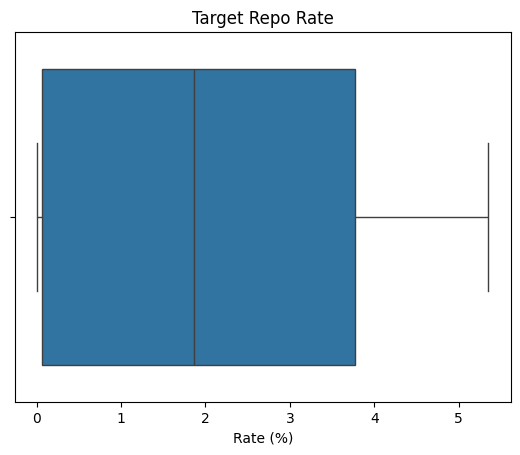

In [ ]:
# Visualization using boxplot
sns.boxplot(x=df_final2['Rate (%)'])
plt.title('Target Repo Rate')
plt.show()

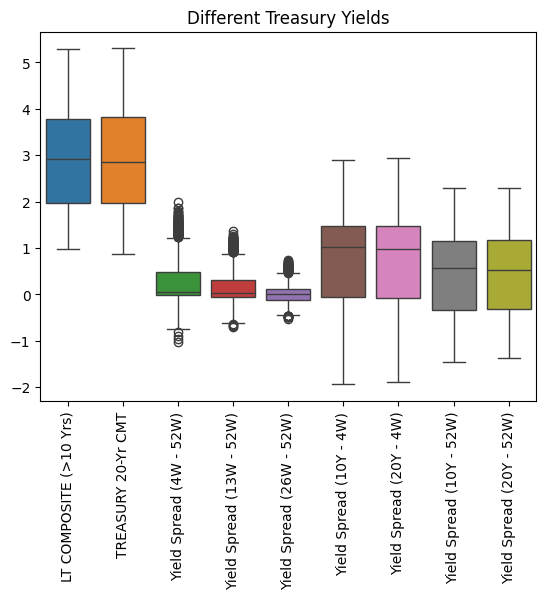

In [ ]:
columns_to_plot = [
    "LT COMPOSITE (>10 Yrs)",
    "TREASURY 20-Yr CMT",
    "Yield Spread (4W - 52W)",
    "Yield Spread (13W - 52W)",
    "Yield Spread (26W - 52W)",
    "Yield Spread (10Y - 4W)",
    "Yield Spread (20Y - 4W)",
    "Yield Spread (10Y - 52W)",
    "Yield Spread (20Y - 52W)"
]

# Create the boxplot for the selected columns
sns.boxplot(data=df_final2[columns_to_plot])
plt.title('Different Treasury Yields')
plt.xticks(rotation=90)
plt.show()

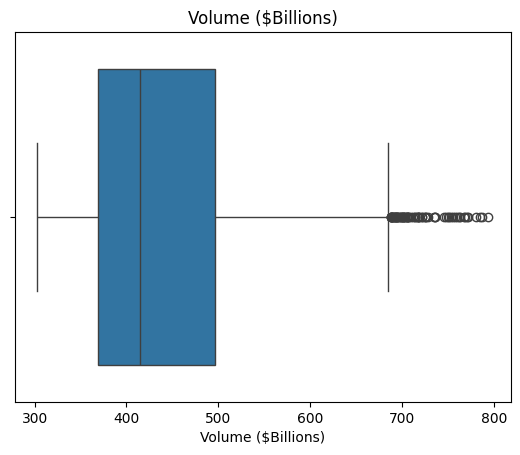

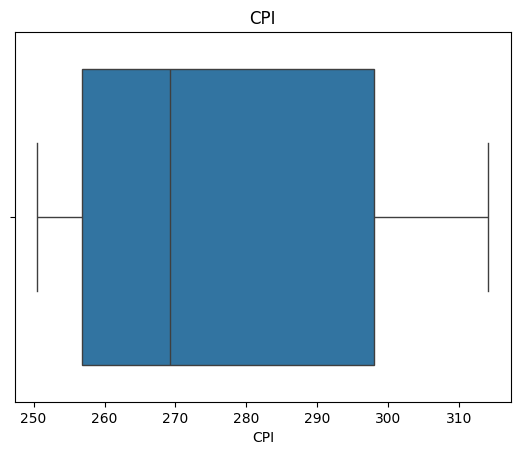

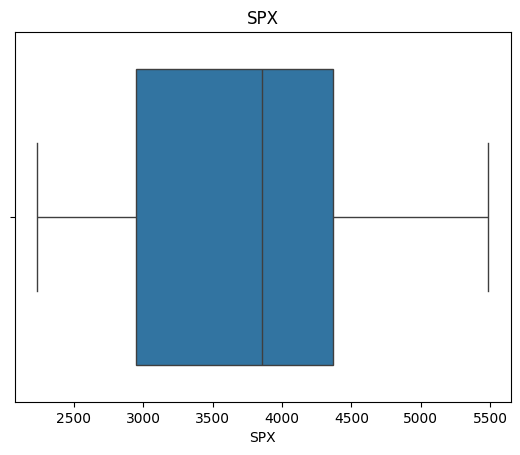

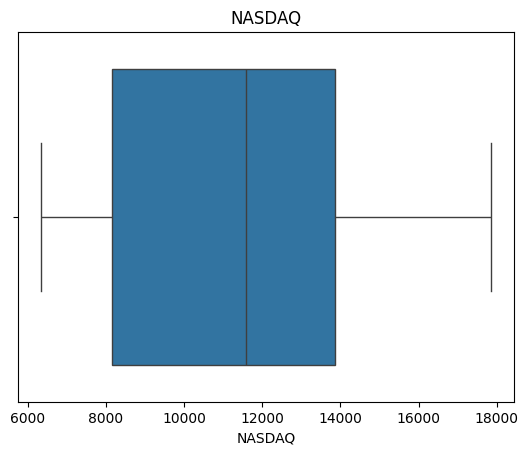

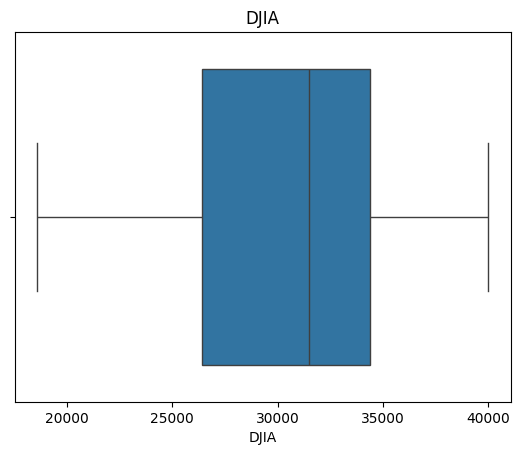

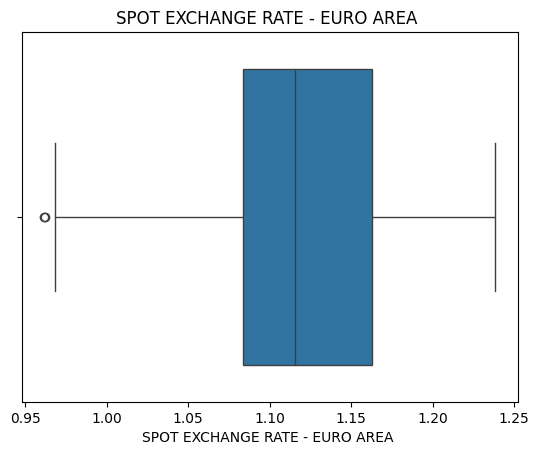

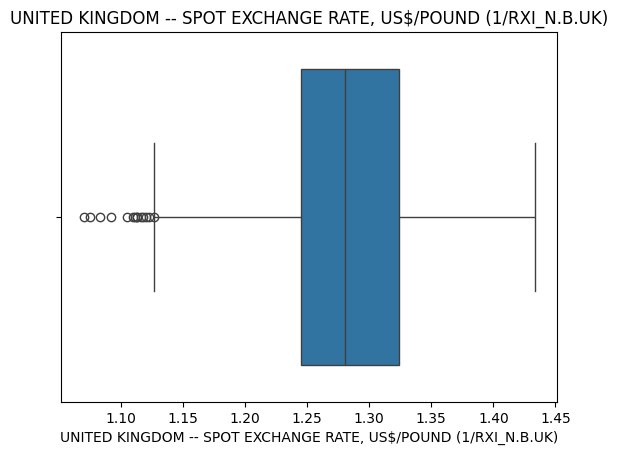

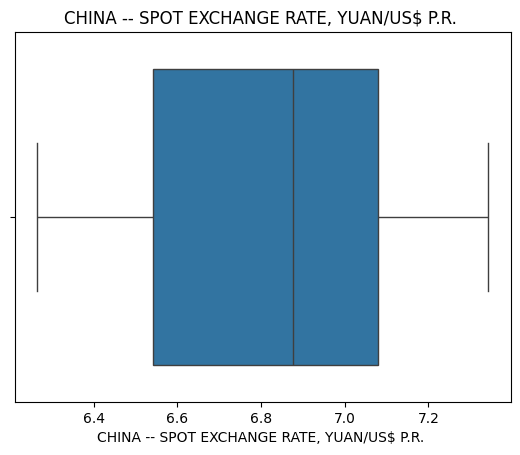

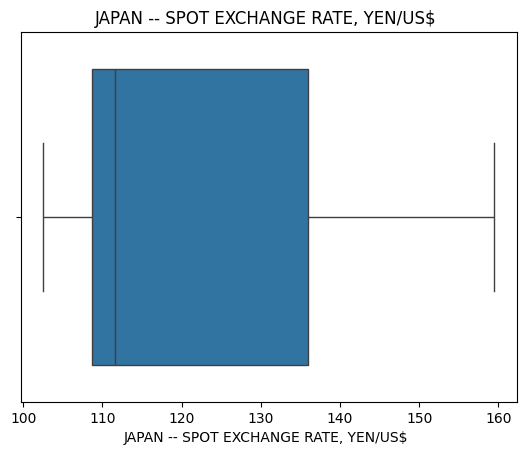

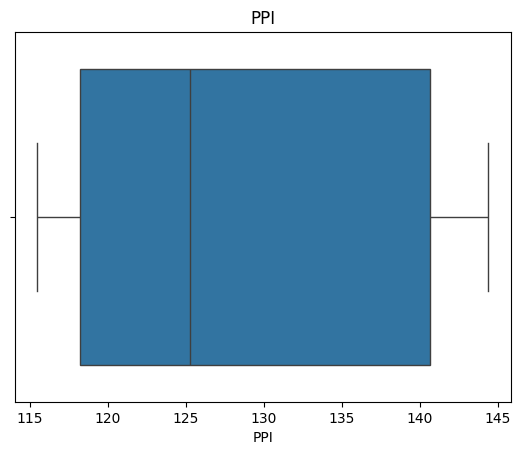

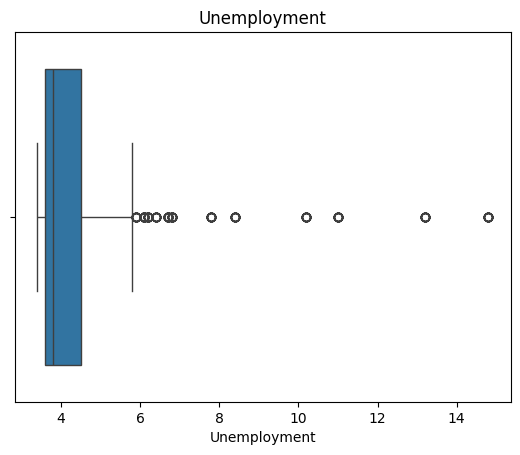

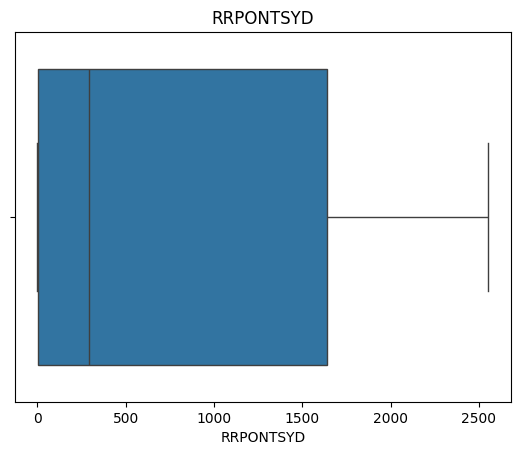

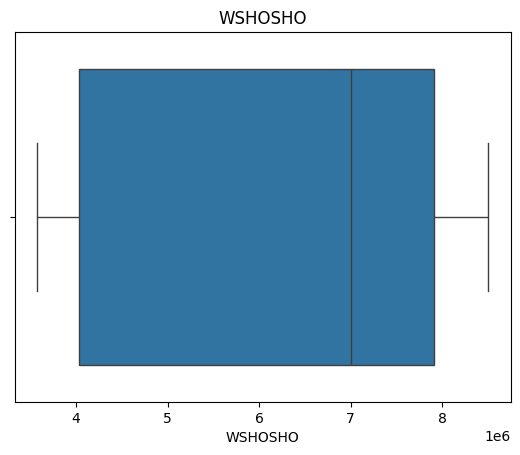

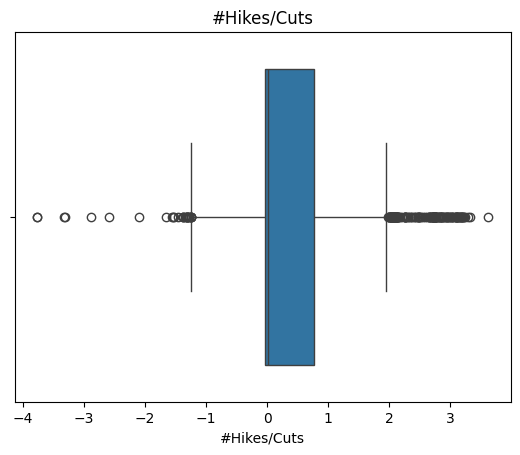

In [ ]:
# List of columns to plot
columns_to_plot = [
    "Volume ($Billions)",
    "CPI",
    "SPX",
    "NASDAQ",
    "DJIA",
    "SPOT EXCHANGE RATE - EURO AREA ",
    "UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)",
    "CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R. ",
    "JAPAN -- SPOT EXCHANGE RATE, YEN/US$ ",
    "PPI",
    "Unemployment",
    "RRPONTSYD",
    "WSHOSHO",
    "#Hikes/Cuts"
]

# Loop through each column and plot
for column in columns_to_plot:
    sns.boxplot(x=df_final2[column])
    plt.title(column)
    plt.show()

# Train / Test Split

In [57]:
# Split into train and test

train = df_final2[:'2022-12-31']
test = df_final2['2023-01-01':]

In [58]:
# Split into X & y
y_train = train['Rate (%)']
X_train = train.drop(columns=['Rate (%)'])
y_test = test['Rate (%)']
X_test = test.drop(columns=['Rate (%)'])

# Feature Engineering: Examine Potential Co-Linearity

In [ ]:
# Combine X and y into a single dataframe for simplicity
data = pd.concat([X_train, y_train], axis =1)

# Calculate correlation matrix
corr = data.corr()

# Display correlation matrix
pd.set_option('display.max_columns', 10)
print(corr)

                                                    Volume ($Billions)  \
Volume ($Billions)                                            1.000000   
LT COMPOSITE (>10 Yrs)                                       -0.019030   
Yield Spread (4W - 52W)                                      -0.408014   
Yield Spread (26W - 52W)                                     -0.492711   
Yield Spread (10Y - 4W)                                      -0.731090   
Yield Spread (10Y - 52W)                                     -0.463900   
NASDAQ                                                       -0.651742   
DJIA                                                         -0.594310   
SPOT EXCHANGE RATE - EURO AREA                               -0.252755   
UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND...           -0.429750   
CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.                    0.669230   
JAPAN -- SPOT EXCHANGE RATE, YEN/US$                         -0.187068   
Unemployment                          

<ipython-input-99-2e03a7c0e7f5>:14: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  plt.gca().add_patch(plt.Circle((j, i),


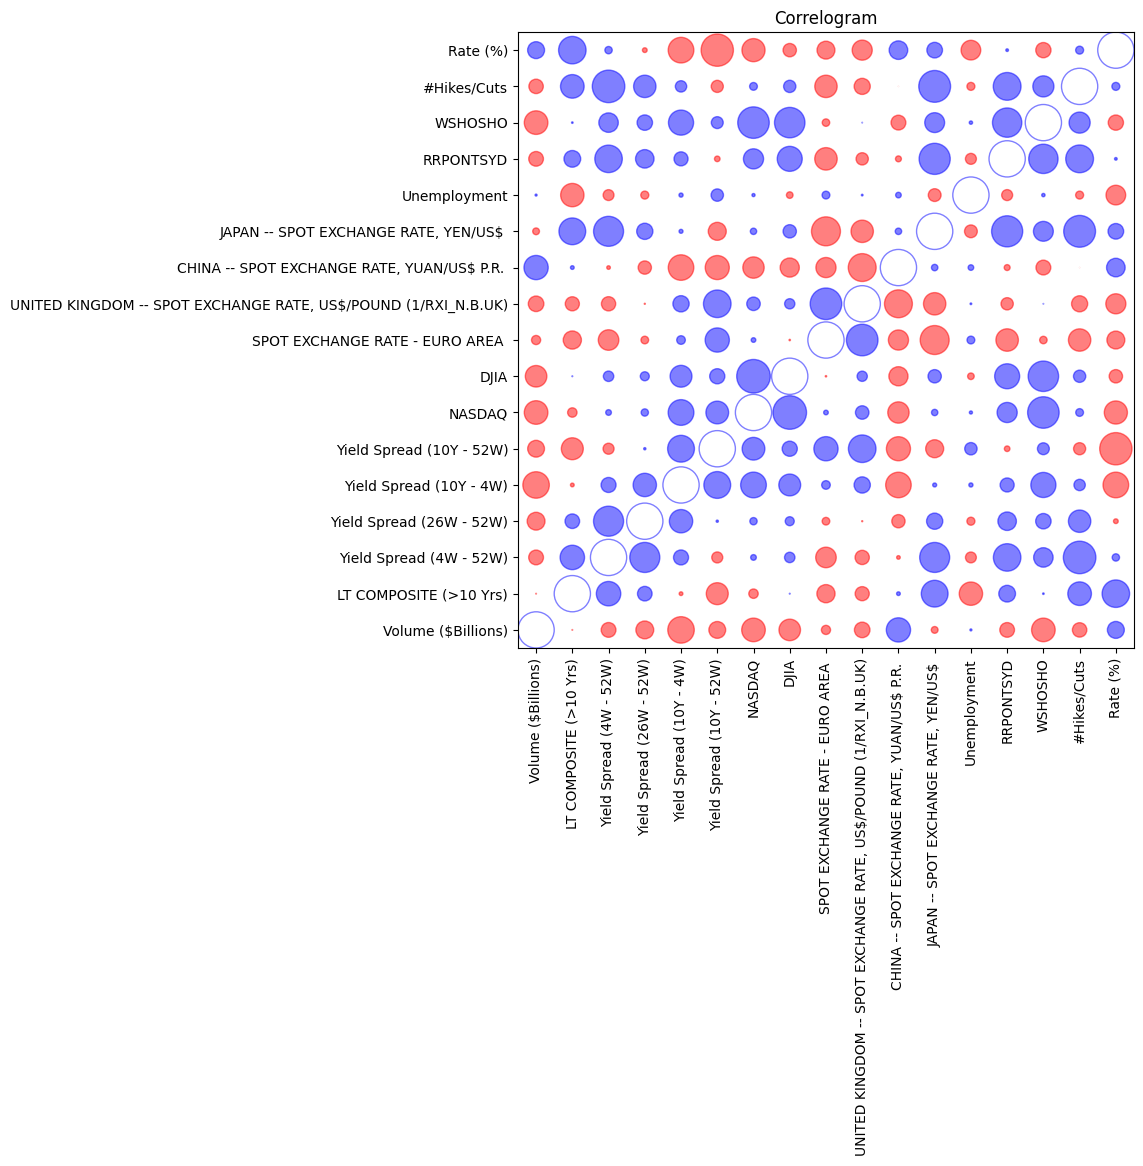

In [ ]:
# display correlation matrix visually

# Initialize figure
plt.figure(figsize=(8, 8))
for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        # Determine the color based on positive or negative correlation
        color = 'blue' if corr.iloc[i, j] > 0 else 'red'

        # don't fill in circles on the diagonal
        fill = not( i == j )

        # Plot the circle with size corresponding to the absolute value of correlation
        plt.gca().add_patch(plt.Circle((j, i),
                                       0.5 * np.abs(corr.iloc[i, j]),
                                       color=color,
                                       edgecolor=color,
                                       fill=fill,
                                       alpha=0.5))



plt.xlim(-0.5, len(corr.columns) - 0.5)
plt.ylim(-0.5, len(corr.columns) - 0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.title('Correlogram')
plt.show()

In [ ]:
# Identify features that have a correlation above a certain threshold
threshold = 0.95
high_corr_features = np.where(np.abs(corr) > threshold)
high_corr_features = [(corr.index[x], corr.columns[y]) for x, y in zip(*high_corr_features) if x != y and x < y]

print("Highly correlated features (above threshold):")
print(high_corr_features)

Highly correlated features (above threshold):
[]


In [ ]:
target_correlation = corr[y_train.name]
print("Correlation with the target variable:")
print(target_correlation)

Correlation with the target variable:
Volume ($Billions)                                                0.467481
LT COMPOSITE (>10 Yrs)                                            0.758930
Yield Spread (4W - 52W)                                           0.203339
Yield Spread (26W - 52W)                                         -0.130154
Yield Spread (10Y - 4W)                                          -0.708067
Yield Spread (10Y - 52W)                                         -0.891406
NASDAQ                                                           -0.638161
DJIA                                                             -0.369495
SPOT EXCHANGE RATE - EURO AREA                                   -0.494190
UNITED KINGDOM -- SPOT EXCHANGE RATE, US$/POUND (1/RXI_N.B.UK)   -0.554098
CHINA -- SPOT EXCHANGE RATE, YUAN/US$ P.R.                        0.512746
JAPAN -- SPOT EXCHANGE RATE, YEN/US$                              0.431713
Unemployment                                                  

Out of the highly corelated features that are above the threshold, we decided to remove the following features in second iteration based on 1) domain knowledge; 2) relative low correlation with the target variable: 'TREASURY 20-Yr CMT', 'Yield Spread (13W - 52W)', 'Yield Spread (20Y - 4W)', 'Yield Spread (20Y - 52W)','CPI', 'SPX', 'PPI'

# Preparing for Model Training


In [59]:
# Apply MinMaxScaler to all features
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

In [62]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Define the sequence length
seq_length = 1

# Generate sequences for training and test sets
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, seq_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, seq_length)

# Check the shapes of the sequences
print(f"Training sequences: {X_train_seq.shape}, Training targets: {y_train_seq.shape}")
print(f"Testing sequences: {X_test_seq.shape}, Testing targets: {y_test_seq.shape}")

Training sequences: (1173, 1, 16), Training targets: (1173,)
Testing sequences: (366, 1, 16), Testing targets: (366,)


<ipython-input-62-d1bf693c2b5d>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(target[i+seq_length])


# Model Training, Prediction & Evaluation

##Baseline Model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.4580
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5740
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2018
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7976
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3773
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2715
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2546
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2163
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2214
Epoch 10/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1983
Epoch 11/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1927
Epoch 12/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1797
Epoch 13/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1582
Epoch 14/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1593
Epoch 15/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1376
Epoch 16/50
37/37 ━━━━━━━━━━━━

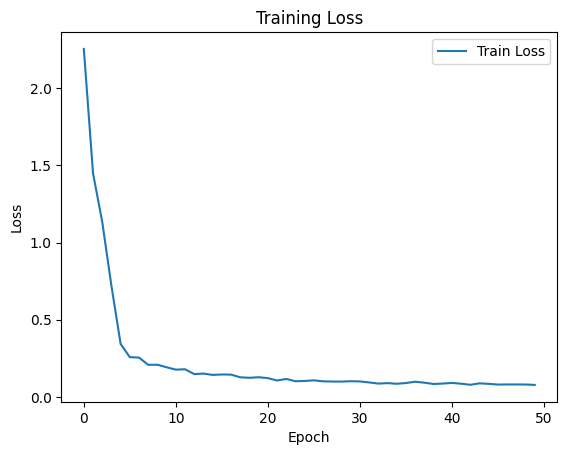

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training RMSE: 0.1638867594509069
Training MAE: 0.08831192681691327
Training MSE: 0.026858869923319414
Training R-squared: 0.9791282166390092
Adjusted Training R-squared: 0.9788393338243242
Test RMSE: 0.656793102812439
Test MAE: 0.5637552050032901
Test MSE: 0.431377179901991
Test R-squared: -3.1983217433450166
Adjusted Test R-squared: -3.3907949464783123


In [63]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(10, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model using the original target variables
history = model.fit(X_train_seq, y_train_seq, batch_size=32, epochs=50)

# Plot training history (Loss over epochs)
plt.plot(history.history['loss'], label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

# Evaluate the model on the training data
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Calculate evaluation metrics directly
rmse_train = np.sqrt(mean_squared_error(y_train_seq, y_train_pred))
mae_train = mean_absolute_error(y_train_seq, y_train_pred)
mse_train = mean_squared_error(y_train_seq, y_train_pred)
r_squared_train = r2_score(y_train_seq, y_train_pred)

print(f'Training RMSE: {rmse_train}')
print(f'Training MAE: {mae_train}')
print(f'Training MSE: {mse_train}')
print(f'Training R-squared: {r_squared_train}')

# Calculate Adjusted R-squared for training data
n_train = y_train_seq.shape[0]  # Number of training data points
p_train = X_train_seq.shape[2]  # Number of predictors (features)
adjusted_r2_train = 1 - (1 - r_squared_train) * (n_train - 1) / (n_train - p_train - 1)
print(f'Adjusted Training R-squared: {adjusted_r2_train}')

# Evaluate the model on the test data
rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
mae_test = mean_absolute_error(y_test_seq, y_test_pred)
mse_test = mean_squared_error(y_test_seq, y_test_pred)
r_squared_test = r2_score(y_test_seq, y_test_pred)

print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test R-squared: {r_squared_test}')

# Calculate Adjusted R-squared for test data
n_test = y_test_seq.shape[0]  # Number of test data points
p_test = X_test_seq.shape[2]  # Number of predictors (features)
adjusted_r2_test = 1 - (1 - r_squared_test) * (n_test - 1) / (n_test - p_test - 1)
print(f'Adjusted Test R-squared: {adjusted_r2_test}')



##Early Stopping

We tried to manually tweak the model (e.g., increase dropout and reduce LSTM units) but the model performance did not improve much and still shows overfitting. To introduce early stopping, we further split the training data into X_train_small and X_val

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 3.3708 - val_loss: 2.3489
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 2.0346 - val_loss: 1.3268
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.1633 - val_loss: 0.8838
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 0.8006 - val_loss: 0.4639
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.5041 - val_loss: 0.2289
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.2512 - val_loss: 0.1669
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1992 - val_loss: 0.1168
Epoch 8/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1375 - val_loss: 0.0985
Epoch 9/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1224 - val_loss: 0.0724
Epoch 10/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.1099 - val_loss: 0.0627
Epoch 11/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0978 - val_loss: 0.0548
Epoch 12/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0853 - val_l

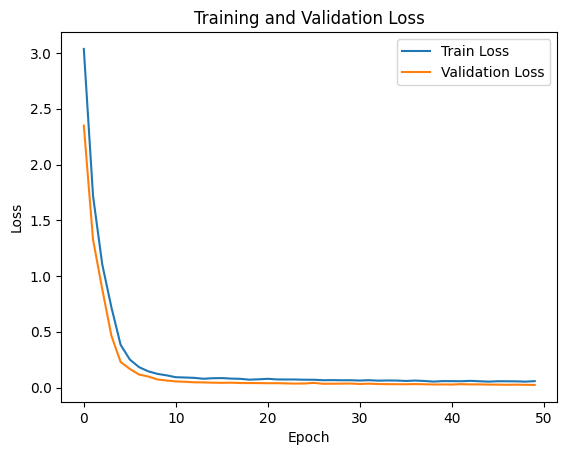

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Training RMSE: 0.1651431449274399
Training MAE: 0.08910745694836068
Training MSE: 0.027272258316525414
Training R-squared: 0.9792279416144152
Adjusted Training R-squared: 0.9789330410517094
Test RMSE: 0.7251733886974486
Test MAE: 0.6991625525477377
Test MSE: 0.5258764436749409
Test R-squared: -7.917857376265868
Adjusted Test R-squared: -8.363750245079162


In [ ]:
# Split the training data into a smaller training set and a validation set
X_train_small, X_val, y_train_small, y_val = train_test_split(X_train_seq, y_train_seq, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train_small, y_train_small, validation_data=(X_val, y_val),
                    epochs=50, batch_size=32, callbacks=[early_stopping])

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate the model on the training data
y_train_pred = model.predict(X_train_seq)
y_test_pred = model.predict(X_test_seq)

# Calculate evaluation metrics directly
rmse_train = np.sqrt(mean_squared_error(y_train_seq, y_train_pred))
mae_train = mean_absolute_error(y_train_seq, y_train_pred)
mse_train = mean_squared_error(y_train_seq, y_train_pred)
r_squared_train = r2_score(y_train_seq, y_train_pred)

print(f'Training RMSE: {rmse_train}')
print(f'Training MAE: {mae_train}')
print(f'Training MSE: {mse_train}')
print(f'Training R-squared: {r_squared_train}')

n_train = y_train_seq.shape[0]
p_train = X_train_seq.shape[2]
adjusted_r2_train = 1 - (1 - r_squared_train) * (n_train - 1) / (n_train - p_train - 1)
print(f'Adjusted Training R-squared: {adjusted_r2_train}')

# Evaluate the model on the test data
rmse_test = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
mae_test = mean_absolute_error(y_test_seq, y_test_pred)
mse_test = mean_squared_error(y_test_seq, y_test_pred)
r_squared_test = r2_score(y_test_seq, y_test_pred)

print(f'Test RMSE: {rmse_test}')
print(f'Test MAE: {mae_test}')
print(f'Test MSE: {mse_test}')
print(f'Test R-squared: {r_squared_test}')

n_test = y_test_seq.shape[0]
p_test = X_test_seq.shape[2]
adjusted_r2_test = 1 - (1 - r_squared_test) * (n_test - 1) / (n_test - p_test - 1)
print(f'Adjusted Test R-squared: {adjusted_r2_test}')

## Optuna Hyperparameter Tuning

In [ ]:
import optuna

In [ ]:
def objective(trial):
    # Suggest hyperparameters with a focus on simpler models and more regularization
    seq_length = trial.suggest_int('seq_length', 1, 30)
    lstm_units = trial.suggest_categorical('lstm_units', [8, 16, 32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.4)  # Lower max dropout
    l2_reg = trial.suggest_float('l2_reg', 1e-6, 1e-2)  # Adjust L2 regularization range
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1e-2)  # Adjust learning rate
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Build the model
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(seq_length, X_train_seq.shape[2]), kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=False, kernel_regularizer=l2(l2_reg)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    # Train the model
    try:
        history = model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=50,
                            callbacks=[KerasPruningCallback(trial, 'val_loss'), early_stopping], verbose=0)
    except Exception as e:
        # Handle any errors that occur during training
        return float('inf')  # Return a very high loss

    # Compute the validation loss
    val_loss = min(history.history['val_loss'])

    return val_loss

# Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best hyperparameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)


[I 2024-08-16 21:35:21,090] A new study created in memory with name: no-name-a3bb9887-c594-4db0-83b9-35558829481b
<ipython-input-58-aa05796fc95b>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-7, 1e-2)  # Adjust learning rate
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-08-16 21:35:21,164] Trial 0 finished with value: inf and parameters: {'seq_length': 28, 'lstm_units': 64, 'dropout_rate': 0.2922483419941267, 'l2_reg': 0.00625201550709482, 'learning_rate': 0.00028977441048728264, 'batch_size': 16}. Best is trial 0 with va

Best Hyperparameters: {'seq_length': 28, 'lstm_units': 64, 'dropout_rate': 0.2922483419941267, 'l2_reg': 0.00625201550709482, 'learning_rate': 0.00028977441048728264, 'batch_size': 16}


##Cross-Validation with Best Params

In [ ]:
# Extract best parameters from Optuna
best_seq_length = best_params['seq_length']
best_lstm_units = best_params['lstm_units']
best_dropout_rate = best_params['dropout_rate']
best_l2_reg = best_params['l2_reg']
best_learning_rate = best_params['learning_rate']
batch_size_rate = best_params['batch_size']

# TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Initialize lists to store metrics for each fold
train_rmse_list = []
test_rmse_list = []
train_r2_list = []
test_r2_list = []
train_adj_r2_list = []
test_adj_r2_list = []

# Dictionary to store metrics for each fold
fold_metrics = {}

for fold, (train_index, test_index) in enumerate(tscv.split(X_train_seq)):
    X_train_fold, X_test_fold = X_train_seq[train_index], X_train_seq[test_index]
    y_train_fold, y_test_fold = y_train_seq[train_index], y_train_seq[test_index]

    # Build and compile the model with best parameters
    model = Sequential()
    model.add(LSTM(best_lstm_units, return_sequences=True, input_shape=(best_seq_length, X_train_fold.shape[2]), kernel_regularizer=l2(best_l2_reg)))
    model.add(Dropout(best_dropout_rate))
    model.add(LSTM(best_lstm_units, return_sequences=False, kernel_regularizer=l2(best_l2_reg)))
    model.add(Dropout(best_dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mean_squared_error')

    # Train the model with early stopping and validation from the training fold
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train_fold, y_train_fold, validation_split=0.2,
                        epochs=100, batch_size=batch_size_rate, callbacks=[early_stopping], verbose=0)

    # Predict on the training and test folds
    y_train_pred_fold = model.predict(X_train_fold)
    y_test_pred_fold = model.predict(X_test_fold)

    # Calculate RMSE for training and test folds
    rmse_train_fold = np.sqrt(mean_squared_error(y_train_fold, y_train_pred_fold))
    rmse_test_fold = np.sqrt(mean_squared_error(y_test_fold, y_test_pred_fold))

    # Calculate R-squared for training and test folds
    r2_train_fold = r2_score(y_train_fold, y_train_pred_fold)
    r2_test_fold = r2_score(y_test_fold, y_test_pred_fold)

    # Calculate Adjusted R-squared for training and test folds
    n_train = X_train_fold.shape[0]
    p = X_train_fold.shape[2]
    adj_r2_train_fold = 1 - (1 - r2_train_fold) * (n_train - 1) / (n_train - p - 1)

    n_test = X_test_fold.shape[0]
    adj_r2_test_fold = 1 - (1 - r2_test_fold) * (n_test - 1) / (n_test - p - 1)

    # Store the results
    train_rmse_list.append(rmse_train_fold)
    test_rmse_list.append(rmse_test_fold)
    train_r2_list.append(r2_train_fold)
    test_r2_list.append(r2_test_fold)
    train_adj_r2_list.append(adj_r2_train_fold)
    test_adj_r2_list.append(adj_r2_test_fold)

    # Store fold metrics
    fold_metrics[fold] = {
        'train_rmse': rmse_train_fold,
        'test_rmse': rmse_test_fold,
        'train_r2': r2_train_fold,
        'test_r2': r2_test_fold,
        'train_adj_r2': adj_r2_train_fold,
        'test_adj_r2': adj_r2_test_fold
    }

    # Print fold metrics
    print(f"Fold {fold + 1}:")
    print(f"  Training RMSE: {rmse_train_fold}")
    print(f"  Test RMSE: {rmse_test_fold}")
    print(f"  Training R-squared: {r2_train_fold}")
    print(f"  Test R-squared: {r2_test_fold}")
    print(f"  Training Adjusted R-squared: {adj_r2_train_fold}")
    print(f"  Test Adjusted R-squared: {adj_r2_test_fold}")
    print("-" * 40)

# Average metrics across all folds
average_train_rmse = np.mean(train_rmse_list)
average_test_rmse = np.mean(test_rmse_list)
average_train_r2 = np.mean(train_r2_list)
average_test_r2 = np.mean(test_r2_list)
average_train_adj_r2 = np.mean(train_adj_r2_list)
average_test_adj_r2 = np.mean(test_adj_r2_list)

print("Average Metrics Across All Folds:")
print(f"Average Training RMSE: {average_train_rmse}")
print(f"Average Test RMSE: {average_test_rmse}")
print(f"Average Training R-squared: {average_train_r2}")
print(f"Average Test R-squared: {average_test_r2}")
print(f"Average Training Adjusted R-squared: {average_train_adj_r2}")
print(f"Average Test Adjusted R-squared: {average_test_adj_r2}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 1:
  Training RMSE: 0.17156922381698617
  Test RMSE: 0.40386529526278664
  Training R-squared: 0.5564318132378865
  Test R-squared: -0.1299654331294111
  Training Adjusted R-squared: 0.5163352539825543
  Test Adjusted R-squared: -0.23447090671363413
----------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step
Fold 2:
  Training RMSE: 0.2795493762497868
  Test RMSE: 1.5402476903521356
  Training R-squared: 0.27795806024812597
  Test R-squared: -3.917336784671999
  Training Adjusted R-squared: 0.24647939257501972
  Test Adjusted R-squared: -4.372119377474034
----------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Fold 3:
  Training RMSE: 0.21840055129188993
  Test RMSE: 0.19802266602738394
  Training R-squared: 0.9382707370623711
  Test R-squared: -56.828923808153206
  Training Adjusted R-squared: 0.9364975445901951
  Test Adjusted R-squared: -62.177263582317664
----------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 4:
  Training RMSE: 0.15174584782986753
  Test RMSE: 0.07801293170809571
  Training R-squared: 0.9780538277504387
  Test R-squared: -1.4143432114756203
  Training Adjusted R-squared: 0.9775837624813718
  Test Adjusted R-squared: -1.6376350691843484
----------------------------------------


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 5:
  Training RMSE: 0.14277432182652056
  Test RMSE: 0.8975207403151908
  Training R-squared: 0.9807302235798813
  Test R-squared: 0.486169056594171
  Training Adjusted R-squared: 0.9804011772375953
  Test Adjusted R-squared: 0.43864711963178216
----------------------------------------
Average Metrics Across All Folds:
Average Training RMSE: 0.19280786420301022
Average Test RMSE: 0.6235338647331184
Average Training R-squared: 0.7462889323757407
Average Test R-squared: -12.360880036167213
Average Training Adjusted R-squared: 0.7314594261733472
Average Test Adjusted R-squared: -13.596568363211578


# Feature Importance

Method 1: Tree-Based Approach

While random forest is a straight-forward approach to capture non-linearity between features and tagret variable, one of its underlying assumptions is that each observation is independent and therefore does not account for the temporal dependecies of our data.

In [ ]:
X = df_final2.drop(columns=['Rate (%)'])  # Features
y = df_final2['Rate (%)']  # Target

# Fit a Random Forest model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame to view feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:\n")
feature_importance_df.sort_values(by='Importance', ascending=False)


Feature Importances:



,Feature,Importance
18,PPI,0.776122
8,Yield Spread (10Y - 52W),0.170425
21,WSHOSHO,0.026594
9,Yield Spread (20Y - 52W),0.010446
1,LT COMPOSITE (>10 Yrs),0.004215
12,NASDAQ,0.002412
22,#Hikes/Cuts,0.002392
10,CPI,0.001328
2,TREASURY 20-Yr CMT,0.001056
14,SPOT EXCHANGE RATE - EURO AREA,0.000999


Method 2: Use SHAP (SHapley Additive exPlanations) to understand which features contribute most to the predictions, especially for time-series data using LSTM.

NOTE: because SHAP expects the input to be in 2D format, df need to be reshared first, resulting in large number of features. To handle this high-dimensional data, we also applied PCA to capture the majority of the variance in the data.

X_train_2d.shape: (1144, 690)
X_test_2d.shape: (337, 690)
X_train_pca.shape: (1144, 100)
X_test_pca.shape: (337, 100)
data_reshaped shape: (1144, 30, 23)
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


  0%|          | 0/337 [00:00<?, ?it/s]

data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 87 iterations, alpha=1.992e-05, previous alpha=1.992e-05, with an active set of 46 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 19 iterations, i.e. alpha=9.267e-03, with an active set of 17 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 30 iterations, alpha=4.643e-03, previous alpha=4.531e-03, with an active set of 23 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 62 iterations, i.e. alpha=1.503e-05, with an active set of 48 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 63 iterations, alpha=1.503e-05, previous alpha=1.448e-05, with an active set of 48 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 25 iterations, i.e. alpha=3.595e-03, with an active set of 23 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 26 iterations, i.e. alpha=3.402e-03, with an active set of 24 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 31 iterations, i.e. alpha=2.094e-03, with an active set of 29 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_it

data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 46 iterations, alpha=1.229e-03, previous alpha=1.209e-03, with an active set of 29 regressors.



data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
data_reshaped shape: (114400, 30, 23)
3575/3575 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step
data_reshaped shape: (1, 30, 23)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
data_reshaped sha

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.916e-01, with an active set of 3 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:639: ConvergenceWarning:

Regressors in active set degenerate. Dropping a regressor, after 15 iterations, i.e. alpha=4.586e-02, with an active set of 13 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_least_angle.py:669: ConvergenceWarning:

Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 67 iterations, alpha=1.830e-02, previous alpha=1.830e-02, with an active set of 40 regressors.

shap_values shape: (337, 100, 1)
X_test_pca shape: (337, 100)
Error during plotting: only integer scalar arrays can be converted to a scalar index
shap_values[0] shape: (100, 1)
shap_values[1] shape: (100, 1)
shap_values[2] shape: (100, 1)
shap_values[3] shape: (100, 1)
shap_values[4] shape: (100, 1)
shap_values[5] shape: (100, 1)
shap_values[6] shape: (100, 1)
shap_values[7] shape: (100, 1)
shap_values[8] shape: (100, 1)
shap_values[9] shape: (100, 1)
shap_values[10] shape: (100, 1)
shap_values[11] shape: (100, 1)
shap_values[12] shape: (100, 1)
shap_values[13] shape: (100, 1)
shap_values[14] shape: (100, 1)
shap_values[15] shape: (100, 1)
shap_values[16] shape: (100, 1)
shap_values[17] shape: (100, 1)
shap_values[18] shape: (100, 1)
shap_values[19] shape: (100, 1)
shap_values[20] shape: (100, 1)
shap_values[21] shape: (100, 1)
shap_values[22] shape: (100, 1)
shap_values[23] shape: (100, 1)
shap_values[24] shape: (100, 1)
shap_values[25] shape: (100, 1)
shap_values[26] shape: (100, 1)

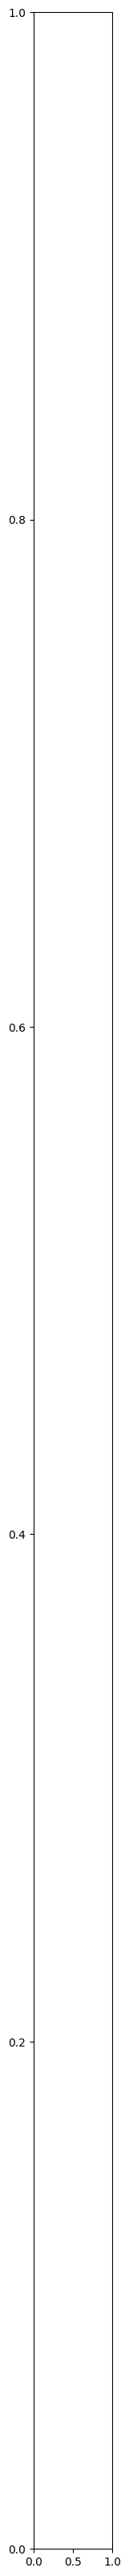

In [ ]:
# Flatten the 3D data to 2D for SHAP explainer
X_train_2d = X_train_seq.reshape((X_train_seq.shape[0], -1))
X_test_2d = X_test_seq.reshape((X_test_seq.shape[0], -1))

# Verify the flattened shapes
print(f'X_train_2d.shape: {X_train_2d.shape}')
print(f'X_test_2d.shape: {X_test_2d.shape}')

# Apply PCA to reduce dimensionality
n_components = 100  # Adjust n_components as needed
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_2d)
X_test_pca = pca.transform(X_test_2d)

# Verify the PCA shapes
print(f'X_train_pca.shape: {X_train_pca.shape}')
print(f'X_test_pca.shape: {X_test_pca.shape}')

# Define the prediction function
def predict_function(data):
    data_reconstructed = pca.inverse_transform(data)
    # The reshaping logic here should be: (num_samples, seq_length, num_features_per_time_step)
    num_features_per_time_step = data_reconstructed.shape[1] // seq_length
    data_reshaped = data_reconstructed.reshape((data.shape[0], seq_length, num_features_per_time_step))
    print(f'data_reshaped shape: {data_reshaped.shape}')  # Print to verify
    return best_model.predict(data_reshaped)

# Use KernelExplainer for SHAP values with reduced data
explainer = shap.KernelExplainer(predict_function, X_train_pca)

# Calculate SHAP values using the test data
shap_values = explainer.shap_values(X_test_pca, nsamples=100)

# Save intermediate results to avoid recomputation
np.save('shap_values.npy', shap_values)
np.save('X_test_pca.npy', X_test_pca)

# Ensure SHAP initialization
shap.initjs()

# Debug: Print shapes to verify consistency
print(f'shap_values shape: {np.array(shap_values).shape}')
print(f'X_test_pca shape: {X_test_pca.shape}')

# Plot SHAP values for feature importance
try:
    shap.summary_plot(
        shap_values,
        X_test_pca,
        feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])],
        max_display=50,
        plot_type='bar'
    )
except TypeError as e:
    print(f"Error during plotting: {e}")
    # Debugging info
    for i, shap_value in enumerate(shap_values):
        print(f'shap_values[{i}] shape: {shap_value.shape}')
    print(f'X_test_pca shape: {X_test_pca.shape}')

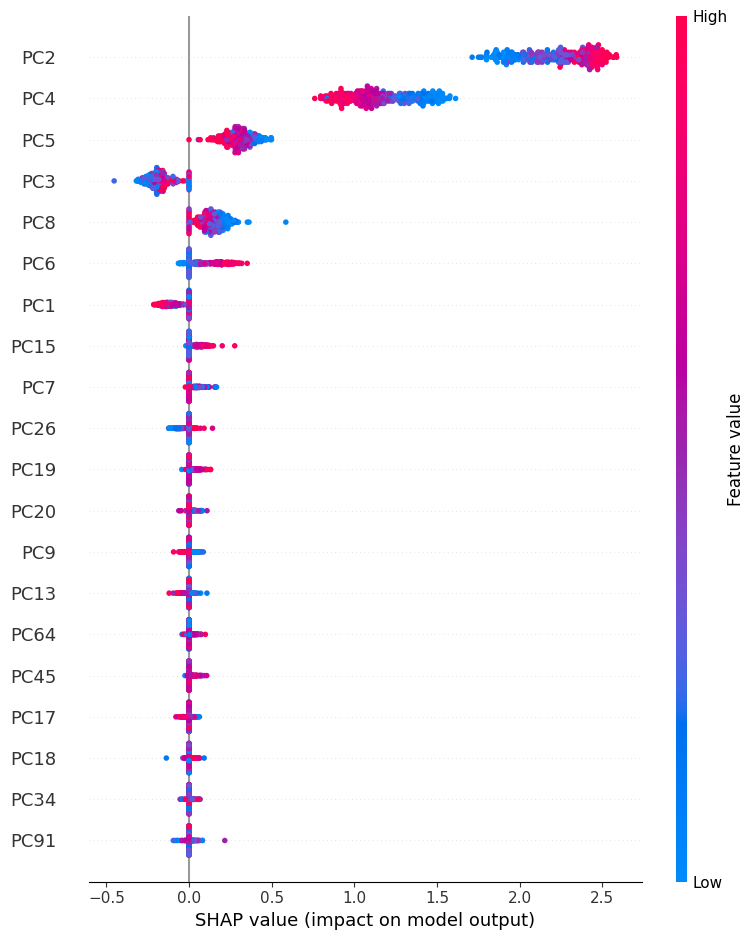

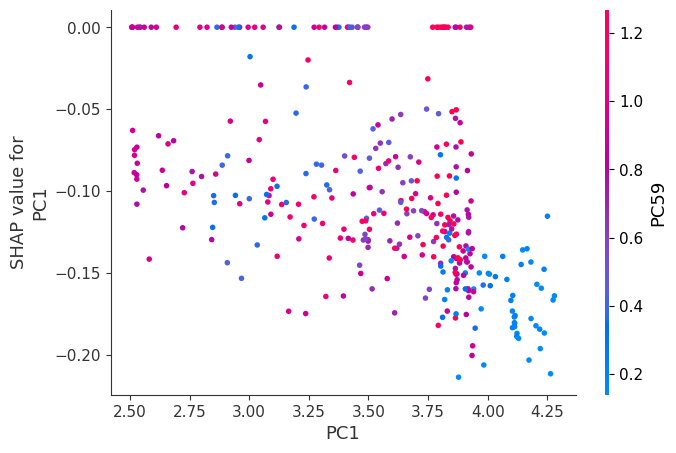

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Reshape shap_values
shap_values_reshaped = np.squeeze(shap_values)

# Plotting summary plot
shap.summary_plot(shap_values_reshaped, X_test_pca, feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

# Plotting a dependence plot for the first principal component
shap.dependence_plot(0, shap_values_reshaped, X_test_pca, feature_names=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])


In [ ]:
# Generate appropriate column names
original_feature_names = df_final2.columns[1:]  # Excluding 'Rate (%)'
time_steps = seq_length
column_names = [f'{feature}_t{t}' for feature in original_feature_names for t in range(time_steps)]

# Create a DataFrame to hold the components and their corresponding feature names
components_df = pd.DataFrame(pca.components_, columns=column_names)

# Print the DataFrame to see the feature names corresponding to each principal component
print(components_df)

# Function to get the top 5 contributing features for each principal component
def get_top_features(components_df, pc_num, top_n=5):
    """
    Get the top N features for a given principal component.

    :param components_df: DataFrame of PCA components.
    :param pc_num: Principal component number (1-based index).
    :param top_n: Number of top features to retrieve.
    :return: Series of top N features and their corresponding weights.
    """
    pc_series = components_df.iloc[pc_num - 1]  # Convert to 0-based index
    top_features = pc_series.abs().sort_values(ascending=False).head(top_n)
    return top_features

# Example: Top 5 contributing features for the first principal component (PC1)
top_features_pc1 = get_top_features(components_df, 1)
print("Top 5 features for PC1:")
print(top_features_pc1)

# Example: Top 5 contributing features for the second principal component (PC2)
top_features_pc2 = get_top_features(components_df, 2)
print("Top 5 features for PC2:")
print(top_features_pc2)

    Volume ($Billions)_t0  Volume ($Billions)_t1  Volume ($Billions)_t2  \
0               -0.030861               0.008058               0.010920   
1                0.021735               0.051471               0.049858   
2               -0.046922               0.053550               0.053085   
3               -0.006240              -0.035398              -0.035200   
4                0.064944              -0.051844              -0.052438   
..                    ...                    ...                    ...   
95               0.135312              -0.008659              -0.006848   
96               0.057212               0.006394               0.003442   
97              -0.053939              -0.001009               0.002857   
98              -0.064314              -0.026925              -0.022948   
99               0.053831               0.027665               0.024959   

    Volume ($Billions)_t3  Volume ($Billions)_t4  ...  #Hikes/Cuts_t25  \
0                0.027104

# Rolling Forecasting

In [ ]:
# Use a portion of X_train_seq as the initial training set
initial_train_size = int(0.7 * len(X_train_seq))  # 70% for initial training
X_initial_train_seq = X_train_seq[:initial_train_size]
y_initial_train_seq = y_train_seq[:initial_train_size]

# Remaining data for rolling forecast
X_rolling_seq = X_train_seq[initial_train_size:]
y_rolling_seq = y_train_seq[initial_train_size:]

In [ ]:
# Extract best parameters from Optuna
best_seq_length = best_params['seq_length']
best_lstm_units = best_params['lstm_units']
best_dropout_rate = best_params['dropout_rate']
best_l2_reg = best_params['l2_reg']
best_learning_rate = best_params['learning_rate']
batch_size_rate = best_params['batch_size']

# Train the LSTM model on the initial training set
model = Sequential()
model.add(LSTM(best_lstm_units, return_sequences=True, input_shape=(seq_length, X_initial_train_seq.shape[2]), kernel_regularizer=l2(best_l2_reg)))
model.add(Dropout(best_dropout_rate))
model.add(LSTM(best_lstm_units, return_sequences=False, kernel_regularizer=l2(best_l2_reg)))
model.add(Dropout(best_dropout_rate))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mean_squared_error')

# Fit the model
model.fit(X_initial_train_seq, y_initial_train_seq, epochs=100, batch_size=batch_size_rate, verbose=0)


In [ ]:
# Initialize lists to store results
rolling_predictions = []
rolling_true_values = []

# Start rolling forecast
for i in range(len(X_rolling_seq)):
    # Predict next step
    X_current = X_rolling_seq[i:i + 1]  # Predict one step ahead
    y_current_true = y_rolling_seq[i:i + 1]

    y_pred = model.predict(X_current)
    rolling_predictions.append(y_pred)
    rolling_true_values.append(y_current_true)

    # Update the model with the new data point
    X_train_updated = np.append(X_initial_train_seq, X_current, axis=0)
    y_train_updated = np.append(y_initial_train_seq, y_current_true, axis=0)

    # Re-fit the model on updated training set
    model.fit(X_train_updated, y_train_updated, epochs=10, batch_size=batch_size_rate, verbose=0)

    # Update the initial training set for the next iteration
    X_initial_train_seq = X_train_updated
    y_initial_train_seq = y_train_updated


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

In [ ]:
# Calculate the overall performance of the rolling forecast
rolling_predictions = np.array(rolling_predictions).flatten()
rolling_true_values = np.array(rolling_true_values).flatten()

# Calculate RMSE and R-squared
rmse = np.sqrt(mean_squared_error(rolling_true_values, rolling_predictions))
r2 = r2_score(rolling_true_values, rolling_predictions)

# Number of observations (n) and predictors (p)
n = len(rolling_true_values)
p = X_train_seq.shape[2]  # Assuming X_train_seq.shape[2] gives the number of features (predictors)

# Calculate Adjusted R-squared
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Print results
print(f'Rolling Forecast RMSE: {rmse}')
print(f'Rolling Forecast R-squared: {r2}')
print(f'Rolling Forecast Adjusted R-squared: {adjusted_r2}')

Rolling Forecast RMSE: 0.2274528500471111
Rolling Forecast R-squared: 0.9727323834614433
Rolling Forecast Adjusted R-squared: 0.9713981881568045


In [ ]:
# Final evaluation on X_test_seq
y_test_pred = model.predict(X_test_seq)

# Calculate RMSE and R-squared
final_rmse = np.sqrt(mean_squared_error(y_test_seq, y_test_pred))
final_r2 = r2_score(y_test_seq, y_test_pred)

# Number of observations (n) and predictors (p)
n = len(y_test_seq)
p = X_test_seq.shape[2]  # Assuming X_test_seq.shape[2] gives the number of features (predictors)

# Calculate Adjusted R-squared
final_adjusted_r2 = 1 - (1 - final_r2) * (n - 1) / (n - p - 1)

# Print results
print(f'Final RMSE on Test Set: {final_rmse}')
print(f'Final R-squared on Test Set: {final_r2}')
print(f'Final Adjusted R-squared on Test Set: {final_adjusted_r2}')

NameError: name 'model' is not defined

#Final Model Training




1.   Reduce seq_length to 1 (i.e., lag = 1)
2.   Apply first-poder differencing and add lagged features
3.   Scale and inverse-scale the target variable in addition to the independent variables
4.   Simplify the LSTM configuration (fewer neurons, layers, batch size etc)




Transform data into supervised learning formt

In [112]:
# Convert string date into datetime
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [113]:
# Transforming data into supervised learning format
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df = df.drop(0)
    return df


In [114]:
# Differencing the series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)


In [115]:
# Data Scaling (normalization)
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [138]:
# inverse scaling for a forecasted value
def invert_transforms(predictions, X, scaler, raw_data):
    inverted = []
    for i in range(len(predictions)):
        yhat = predictions[i]
        X_row = X[i, 0, :]
        inv_scale = scaler.inverse_transform([np.concatenate((X_row, yhat))])
        inv_diff = inv_scale[0, -1] + raw_data[-len(predictions)+i - 1]  # Adjust index accordingly
        inverted.append(inv_diff)
    return inverted

In [127]:
# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
    # Separate
    X, y = scaled_dataset[:, 1:], scaled_dataset[:, 0]  # target is now the first column
    # Reshape
    reshaped = X.reshape(len(X), 1, X.shape[1])
    # Forecast dataset
    output = model.predict(reshaped, batch_size=batch_size)
    # Invert data transforms on forecast
    predictions = list()
    for i in range(len(output)):
        yhat = output[i, 0]
        # Invert scaling
        yhat = invert_scale(scaler, X[i], yhat)
        # Invert differencing
        yhat = yhat + raw_data[i]
        # Store forecast
        predictions.append(yhat)
    # Calculate RMSE
    rmse = sqrt(mean_squared_error(raw_data[1:], predictions))
    # Calculate R-squared
    r_squared = r2_score(raw_data[1:], predictions)
    # Calculate Adjusted R-squared
    n = len(raw_data[1:])
    k = X.shape[1]  # number of predictors
    adj_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - k - 1))

    return rmse, r_squared, adj_r_squared

In [136]:
def fit_lstm(train, test, raw_train, raw_test, scaler, batch_size, nb_epoch, neurons):
    # Prepare input data for LSTM
    X_train, y_train = train[:, 1:], train[:, 0]
    X_test, y_test = test[:, 1:], test[:, 0]

    # Reshape input to be [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, timesteps=1, features)
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))      # (samples, timesteps=1, features)

    # Define LSTM model
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(1, X_train.shape[2]), stateful=False))  # Update: input_shape=(1, features)
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    train_rmse, test_rmse, train_r2, test_r2, train_adj_r2, test_adj_r2 = [], [], [], [], [], []

    for i in range(nb_epoch):
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

        # Make predictions
        train_predict = model.predict(X_train, batch_size=batch_size)
        test_predict = model.predict(X_test, batch_size=batch_size)

        # Invert scaling and differencing
        train_predict = invert_transforms(train_predict, X_train, scaler, raw_train)
        test_predict = invert_transforms(test_predict, X_test, scaler, raw_test)

        # Calculate metrics
        train_rmse_value = sqrt(mean_squared_error(raw_train[-len(train_predict):], train_predict))
        test_rmse_value = sqrt(mean_squared_error(raw_test[-len(test_predict):], test_predict))

        train_r2_value = r2_score(raw_train[-len(train_predict):], train_predict)
        test_r2_value = r2_score(raw_test[-len(test_predict):], test_predict)

        n_train = len(train_predict)
        n_test = len(test_predict)
        k = X_train.shape[2]

        train_adj_r2_value = 1 - (1 - train_r2_value) * (n_train - 1) / (n_train - k - 1)
        test_adj_r2_value = 1 - (1 - test_r2_value) * (n_test - 1) / (n_test - k - 1)

        train_rmse.append(train_rmse_value)
        test_rmse.append(test_rmse_value)
        train_r2.append(train_r2_value)
        test_r2.append(test_r2_value)
        train_adj_r2.append(train_adj_r2_value)
        test_adj_r2.append(test_adj_r2_value)

    history = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_adj_r2': train_adj_r2,
        'test_adj_r2': test_adj_r2
    }

    return history


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
1172/1172 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
365/365 ━━━━━━━━━━━━━━━━━━━━ 0s 1

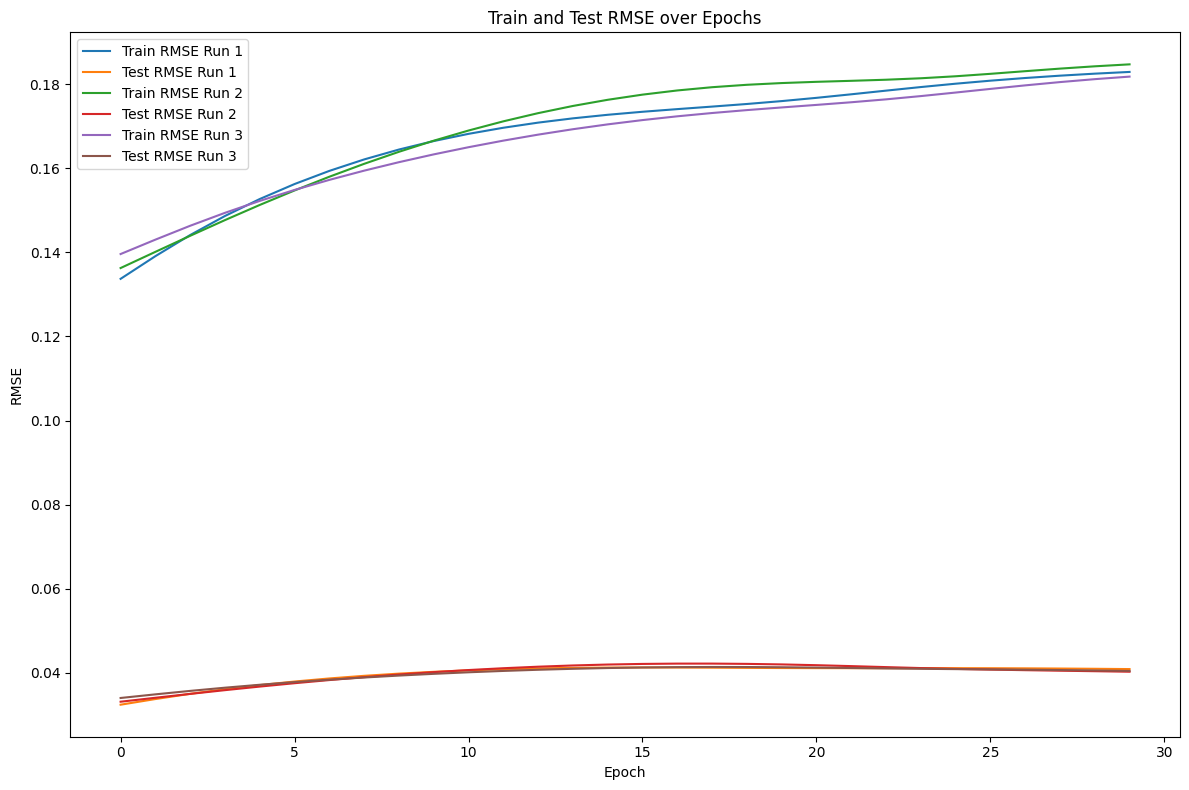

In [137]:
def run():
    # Load and process the dataset
    series = df_final2.iloc[:, 0]  # first column is the target variable
    series.index = pd.to_datetime(series.index)  # Ensure the index is datetime

    # Define train and test split dates
    train_end_date = '2022-12-31'
    test_start_date = '2023-01-01'

    # Split the raw data into train and test sets based on dates
    train_series = series[:train_end_date]
    test_series = series[test_start_date:]

    # Apply differencing to make the series stationary
    diff_train = difference(train_series.values, 1)
    diff_test = difference(test_series.values, 1)

    # Transform data to supervised learning format
    supervised_train = timeseries_to_supervised(diff_train, 1)
    supervised_test = timeseries_to_supervised(diff_test, 1)

    # Convert to numpy arrays
    train_values = supervised_train.values
    test_values = supervised_test.values

    # Scale the data
    scaler, train_scaled, test_scaled = scale(train_values, test_values)

    # Model Configuration
    repeats = 3  # Number of times to repeat the experiment
    n_batch = 1  # Batch size
    n_epochs = 30  # Number of epochs
    n_neurons = 10  # Number of neurons in the LSTM layer

    # Run diagnostic tests
    plt.figure(figsize=(12, 8))
    for i in range(repeats):
        history = fit_lstm(train_scaled, test_scaled, train_series.values, test_series.values, scaler, n_batch, n_epochs, n_neurons)

        # Plot RMSE for training and test data
        plt.plot(history['train_rmse'], label=f'Train RMSE Run {i+1}')
        plt.plot(history['test_rmse'], label=f'Test RMSE Run {i+1}')

        # Print the final RMSE, R-squared, and Adjusted R-squared values for this repeat
        print(f'Run {i+1} Results:')
        print(f'Last Epoch - Train RMSE: {history["train_rmse"][-1]:.4f}, Test RMSE: {history["test_rmse"][-1]:.4f}')
        print(f'Last Epoch - Train R^2: {history["train_r2"][-1]:.4f}, Test R^2: {history["test_r2"][-1]:.4f}')
        print(f'Last Epoch - Train Adjusted R^2: {history["train_adj_r2"][-1]:.4f}, Test Adjusted R^2: {history["test_adj_r2"][-1]:.4f}\n')

    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Train and Test RMSE over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.savefig('epochs_diagnostic.png')
    plt.show()

# Run the modified function
run()

# V0 Final Model (If no differencing applied)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 1/30 - Train RMSE: 1.0415, Train R^2: 0.1570, Train Adjusted R^2: 0.1563, Test RMSE: 0.8353, Test R^2: -5.7908, Test Adjusted R^2: -5.8094
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 2/30 - Train RMSE: 0.1912, Train R^2: 0.9716, Train Adjusted R^2: 0.9716, Test RMSE: 0.5220, Test R^2: -1.6518, Test Adjusted R^2: -1.6591
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 3/30 - Train RMSE: 0.0533, Train R^2: 0.9978, Train Adjusted R^2: 0.9978, Test RMSE: 0.5033, Test R^2: -1.4656, Test Adjusted R^2: -1.4723
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 4/30 - Train RMSE: 0.0633, Train R^2: 0.9969, Train Adjusted R^2: 0.9969, Test RMSE: 0.5195, Test R^2: -1.6263, Test Adjusted R^2: -1.6335
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/30 - Train RMSE: 1.2978, Train R^2: -0.3089, Train Adjusted R^2: -0.3100, Test RMSE: 1.1704, Test R^2: -12.3309, Test Adjusted R^2: -12.3675
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 2/30 - Train RMSE: 0.2614, Train R^2: 0.9469, Train Adjusted R^2: 0.9469, Test RMSE: 0.6051, Test R^2: -2.5629, Test Adjusted R^2: -2.5727
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3/30 - Train RMSE: 0.1042, Train R^2: 0.9916, Train Adjusted R^2: 0.9916, Test RMSE: 0.5424, Test R^2: -1.8630, Test Adjusted R^2: -1.8709
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 4/30 - Train RMSE: 0.1241, Train R^2: 0.9880, Train Adjusted R^2: 0.9880, Test RMSE: 0.5540, Test R^2: -1.9875, Test Adjusted R^2: -1.9957
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/s

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/30 - Train RMSE: 1.3228, Train R^2: -0.3598, Train Adjusted R^2: -0.3610, Test RMSE: 1.2193, Test R^2: -13.4699, Test Adjusted R^2: -13.5097
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 2/30 - Train RMSE: 0.2821, Train R^2: 0.9381, Train Adjusted R^2: 0.9381, Test RMSE: 0.6111, Test R^2: -2.6339, Test Adjusted R^2: -2.6439
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 3/30 - Train RMSE: 0.1077, Train R^2: 0.9910, Train Adjusted R^2: 0.9910, Test RMSE: 0.5399, Test R^2: -1.8371, Test Adjusted R^2: -1.8449
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Epoch 4/30 - Train RMSE: 0.1279, Train R^2: 0.9873, Train Adjusted R^2: 0.9873, Test RMSE: 0.5514, Test R^2: -1.9586, Test Adjusted R^2: -1.9668
1173/1173 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/s

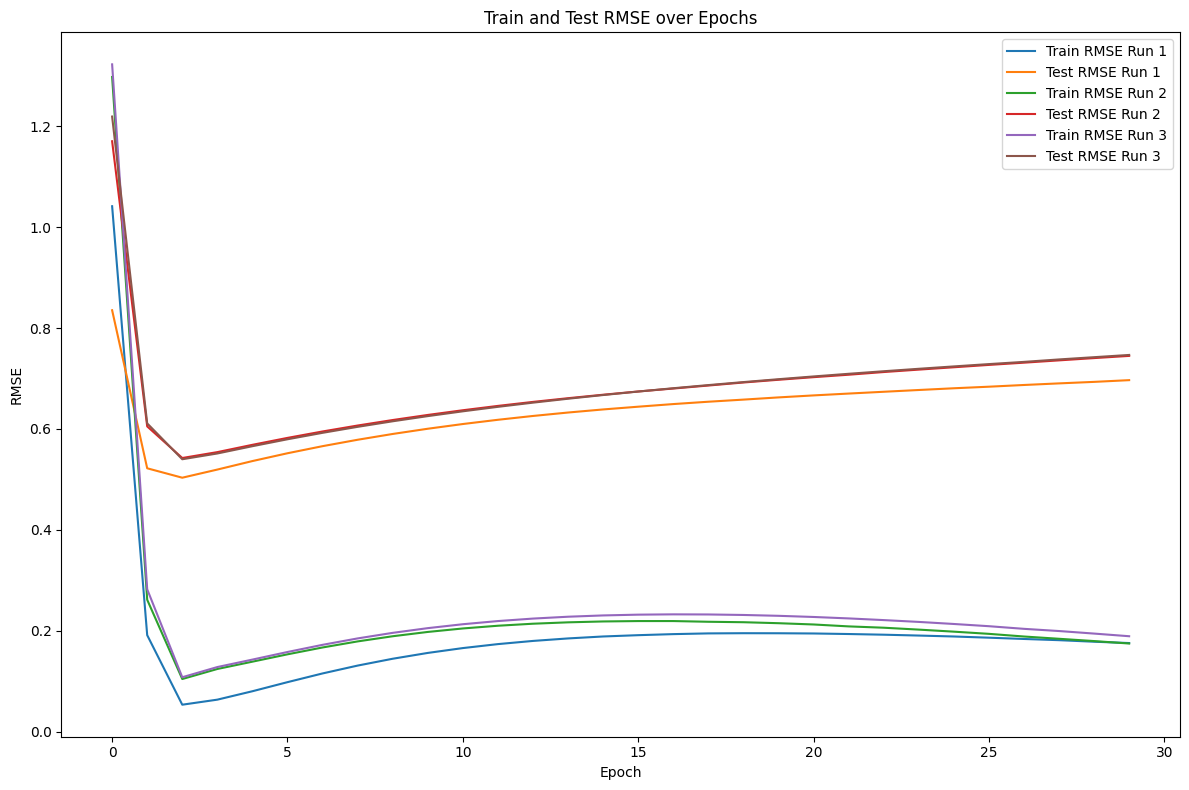

In [27]:
# Function to transform time series data into a supervised learning format
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df_supervised = pd.concat(columns, axis=1)
    df_supervised.dropna(inplace=True)
    return df_supervised

# Function to scale the data
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train)
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# Function to invert scaling for a forecasted value
def invert_scale(scaler, X, yhat):
    new_row = [yhat] + [x for x in X]
    array = np.array(new_row).reshape(1, len(new_row))
    inverted = scaler.inverse_transform(array)
    return inverted[0, 0]  # return the first column (target)

# Function to evaluate the model on a dataset, returns RMSE, R-squared, and Adjusted R-squared
def evaluate(model, raw_data, scaled_dataset, scaler, batch_size):
    X, y = scaled_dataset[:, 1:], scaled_dataset[:, 0]  # target is the first column
    reshaped = X.reshape(len(X), 1, X.shape[1])
    output = model.predict(reshaped, batch_size=batch_size)

    predictions = []
    for i in range(len(output)):
        yhat = output[i, 0]
        yhat = invert_scale(scaler, X[i], yhat)
        predictions.append(yhat)

    rmse = sqrt(mean_squared_error(raw_data[-len(predictions):], predictions))
    r_squared = r2_score(raw_data[-len(predictions):], predictions)
    n = len(predictions)
    k = X.shape[1]
    adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - k - 1)

    return rmse, r_squared, adj_r_squared

# Function to fit an LSTM network to training data
def fit_lstm(train, test, raw_train, raw_test, scaler, batch_size, nb_epoch, neurons):
    X_train, y_train = train[:, 1:], train[:, 0]
    X_test, y_test = test[:, 1:], test[:, 0]

    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    model = Sequential()
    model.add(LSTM(neurons, input_shape=(1, X_train.shape[2]), stateful=False))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    train_rmse, test_rmse = [], []
    train_r2, test_r2 = [], []
    train_adj_r2, test_adj_r2 = [], []

    for i in range(nb_epoch):
        model.fit(X_train, y_train, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

        train_rmse_epoch, train_r2_epoch, train_adj_r2_epoch = evaluate(model, raw_train, train, scaler, batch_size)
        test_rmse_epoch, test_r2_epoch, test_adj_r2_epoch = evaluate(model, raw_test, test, scaler, batch_size)

        train_rmse.append(train_rmse_epoch)
        test_rmse.append(test_rmse_epoch)
        train_r2.append(train_r2_epoch)
        test_r2.append(test_r2_epoch)
        train_adj_r2.append(train_adj_r2_epoch)
        test_adj_r2.append(test_adj_r2_epoch)

        print(f'Epoch {i+1}/{nb_epoch} - Train RMSE: {train_rmse_epoch:.4f}, Train R^2: {train_r2_epoch:.4f}, '
              f'Train Adjusted R^2: {train_adj_r2_epoch:.4f}, Test RMSE: {test_rmse_epoch:.4f}, '
              f'Test R^2: {test_r2_epoch:.4f}, Test Adjusted R^2: {test_adj_r2_epoch:.4f}')

    history = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_adj_r2': train_adj_r2,
        'test_adj_r2': test_adj_r2
    }

    return history

# Main run function
def run():
    # Load and process the dataset
    series = df_final2.iloc[:, 0]  # Assuming df_final2 is your DataFrame and the first column is the target
    series.index = pd.to_datetime(series.index)  # Ensure the index is datetime

    # Define train and test split dates
    train_end_date = '2022-12-31'
    test_start_date = '2023-01-01'

    # Split the raw data into train and test sets based on dates
    train_series = series[:train_end_date]
    test_series = series[test_start_date:]

    # Transform data to supervised learning format
    supervised_train = timeseries_to_supervised(train_series.values, 1)
    supervised_test = timeseries_to_supervised(test_series.values, 1)

    # Convert to numpy arrays
    train_values = supervised_train.values
    test_values = supervised_test.values

    # Scale the data
    scaler, train_scaled, test_scaled = scale(train_values, test_values)

    # Model Configuration
    repeats = 3  # Number of times to repeat the experiment
    n_batch = 1  # Batch size
    n_epochs = 30  # Number of epochs
    n_neurons = 10  # Number of neurons in the LSTM layer

    # Run diagnostic tests
    plt.figure(figsize=(12, 8))
    for i in range(repeats):
        history = fit_lstm(train_scaled, test_scaled, train_series.values, test_series.values, scaler, n_batch, n_epochs, n_neurons)

        # Plot RMSE for training and test data
        plt.plot(history['train_rmse'], label=f'Train RMSE Run {i+1}')
        plt.plot(history['test_rmse'], label=f'Test RMSE Run {i+1}')

        # Print the final RMSE, R-squared, and Adjusted R-squared values for this repeat
        print(f'Run {i+1} Results:')
        print(f'Last Epoch - Train RMSE: {history["train_rmse"][-1]:.4f}, Test RMSE: {history["test_rmse"][-1]:.4f}')
        print(f'Last Epoch - Train R^2: {history["train_r2"][-1]:.4f}, Test R^2: {history["test_r2"][-1]:.4f}')
        print(f'Last Epoch - Train Adjusted R^2: {history["train_adj_r2"][-1]:.4f}, Test Adjusted R^2: {history["test_adj_r2"][-1]:.4f}\n')

    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Train and Test RMSE over Epochs')
    plt.legend()
    plt.tight_layout()
    plt.savefig('epochs_diagnostic.png')
    plt.show()

# Run the modified function
run()
